## E-tivity   - Binary Logistic regression - Task A
There are many situations where some $y$ should be a noisy
representation of some function of $x_1,\ldots,x_p$, but the 
response outcomes $y$ are binary.

Binary logistic regression corresponds to this probabilistic model

$$
p\left(y|w^T x \right)=\phi(w^T x)^{y}(1-\phi(w^T x ))^{1-y}  \text{ for } y=0,1
$$

where $w \in \mathbb{R}^p$ is the vector if coefficient and $\phi(\cdot)$ is some sigmoid function,e.g.,

* Logistic function: $\phi(x)=1/(1+e^{-x})$
* probit function: $\phi(x)=0.5(1+\text{erf}(x/\sqrt{2}))$


Given $N$ training data, the likelihood function assuming that all the observations in the sample are independently Bernoulli distributed is

$$
{\displaystyle {\begin{aligned}L(\theta \mid x)&=\Pr(Y\mid X;\theta )\\&=\prod_{i=1}^Np(y_{i}\mid x_{i};\theta )\\&=\prod _{i=1}^N\phi(w^T x_{i})^{y_{i}}(1-\phi(w^T x_{i}))^{(1-y_{i})}\end{aligned}}}
$$

Our goal is to find the maximum likelihood estimate of the vector of the parameters $w$, that is to solve the optimisation problem

$$
\hat{w} =\arg\max_{w \in \mathbb{R}^p} \prod _{i=1}^N\phi(w^T x_{i})^{y_{i}}(1-\phi(w^T x_{i}))^{(1-y_{i})}
$$

The product of probability (that are numbers between $0$ and $1$) can become very small for large $N$
and can lead to arithmetic underflow problems.
To avoid this problem, one typically maximises the logarithm of the likelihood function (log transform). In fact, one can prove that for any nonnegative function

$$
\arg\max_{x} f(x) = \arg\max_{x} \log(x)  
$$

and, therefore, we actually solve:

$$
\hat{w} =\arg\max_{w \in \mathbb{R}^p}  \sum _{i=1}^{N}y_{i}\log(\phi(w^T x_{i}))+(1-y_{i})\log(1-\phi(w^T x_{i}))
 $$

which is maximized using optimization techniques.

**Reguralisation**
In general-recipe ML, reguralisation is used to reduce the problem of overfitting. 
Therefore, actually the problem we aim to solve is

$$
\hat{w} =\arg\max_{w \in \mathbb{R}^p}  \sum _{i=1}^{N}y_{i}\log(\phi(w^T x_{i}))+(1-y_{i})\log(1-\phi(w^T x_{i})) + \alpha||w||_2^2
 $$
 
 where $ \alpha$ is the reguralisation constant (a design parameter that is usually selected via cross-validation, note that $ \alpha\geq0$) and $||w||_2^2=\sum_{=1}^{p} w_i^2$. 


We assume that you know how logistic regression works: (i) how to compute the predicted probability; (ii) how to return the predicted class.


## Task A
Part 1 Theorethical questions: 

    What type of optimisation problem is it?
    1. Is it univariate or multivariate?
    2. Is it linear or nonlinear?
    3. Is it convex or not? (google it and cite your font, how is the fast way to prove it?)
    4. Is it constrained?

### Task A - Answers
1. Univariate
2. Nonlinear
3. Concave
4. Yes as α >= 0

Part 2: The goal of this part is to reimplement **totally** from scratch the class LogisticRegression, that mimics the corresponding class in `Sklearn`. 
* The class must be flexible: the user can choose any type of differentiable (w.r.t. the parameters $w$) sigmoid function and the class must work for any number of features $p$ (suggestion: use `autograd` library). 
* As optimizer you should use `local_descent` with  `line_research`, see the Webinar 1 notebook.


You can implement the class either in Python or in Julia.

In [1]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from autograd.scipy.special import erf
import autograd.numpy as np
from autograd import grad
from math import sqrt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Golden Retio
ϕ = (1 + sqrt(5))/2

In [2]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
ind = np.where((y==0) | (y==1))[0] # we only have two classes now
X = X[ind,:]
y = y[ind]

In [3]:
y = np.reshape(y, (y.shape[0], 1))
print(y.shape)
print(X.shape)

(100, 1)
(100, 4)


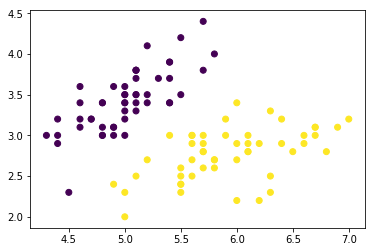

In [4]:
_ = plt.scatter(X[:, 0], X[:, 1], c=y.flatten() )

### Line Search Implementation
The following functions are required to invoke the line search method for optimization

In [5]:
def bracket_minimum(f, x=0, s=1e-2, k=2.0): #From the Book, pag.36
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    if yb > ya:
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    while True:
        c, yc = b + s, f(b + s)
        if yc > yb:
            return (a, c) if a<c else (c, a)        
        a, ya, b, yb = b, yb, c, yc
        s *= k
        
def golden_section_search(f, a, b, max_iter, plotting=True): #from the Book pag.41
    a0 =a
    b0=b
    ρ = φ-1
    d = ρ * b + (1 - ρ)*a
    yd = f(d)
    for i in range(max_iter-1):
        c = ρ*a + (1 - ρ)*b
        yc = f(c)
        if yc < yd:
            b, d, yd = d, c, yc
        else:
            a, b = b, c   
        if plotting==True:
            plt.figure()
            xx = np.linspace(a0,b0,100)
            plt.plot(xx,f(xx))
            plt.scatter(np.array([a,b]),np.array([a,b])*0)
            plt.scatter(np.array([a,b]),np.array([f(a),f(b)]))

    return (a, b) if a<b else (b, a)

def line_search(f, x, d, ϵ_x=0.0001, ϵ_d=0.0001):
    term = False
    if np.linalg.norm(d) < ϵ_d:
        term = True
        return x
    objective = lambda α : f(x + α*d)
    a, b = bracket_minimum(objective)
    a, b = golden_section_search(objective, a, b, max_iter = 5, plotting=False)
    α = (a+b)/2
    if np.linalg.norm(x+a*d-x)<ϵ_x:
        term = True
    return x + α*d, term

def local_descent(β,cost, gradient,steps=1, α=None, ϵ_x=0.0001, ϵ_d=0.0001,  plotting=False):
    Tmp = [β]
    for iteration in range(steps):
        d = gradient(β)
        d = -d/np.linalg.norm(d)
        β, term = line_search(cost, β, d, ϵ_x=ϵ_x, ϵ_d=ϵ_d)
        if term == True:
            break
        Tmp.append(β)
    return Tmp

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Logistic Regression Implementation
The following is an implementation of logistic regression that uses cross entropy as it's cost function and local descent as the optimizer. 

In [116]:
class Generic_LogisticRegression():
    def __init__(self, θ, sigmoid, α=0.01):
        self.θ = θ #initial value of the parameter
        self.sigmoid = sigmoid #a sigmoid function that squezes the input into [0,1]
        self.α = α #reguralisation parameter
        
    def __prob(self, x, theta):
        '''
        Helper that uses sigmoid fucntion to squash the result between zero and one
        '''
        return self.sigmoid(np.dot(x, theta))
    
    def fit(self,x,y):  
        def cost_i(θ):
            '''
            Cost function using cross entropy cost
            '''
            h = self.__prob(x, θ)
            m = x.shape[0]
            # Cross Entropy function
            cost = -(1.0/m) * (np.dot(y.T, np.log(h)) + np.dot((1-y.T), np.log(1-h))) + (self.α * np.sum(θ**2))
            return cost
        
        # Function to calculate gradient
        gradcost = grad(cost_i)
        
        # Updated value for θ
        θ = local_descent(self.θ, cost_i, gradcost, steps=150, α=self.α, ϵ_x=0.0001, ϵ_d=0.0001, plotting=False)
        self.θ = θ[-1]
        
        # Add graphing function to plot the evolution of parameter values
        plt.plot(np.array(θ).squeeze())
        plt.title("θ evolution with each iteration")
        plt.xlabel("iteration")
        # store θ values
        self.θ_iterations = θ
    
    
    def predict_proba(self, x):
        return self.__prob(x, self.θ)
    
    def predict(self, x):
        return np.where(self.predict_proba(x) >= 0.5, 1, 0)       

### Instructions for Use
To use this implementation of logistic regression perform the following steps:
1. Initialize the weights to np.zeros((X.shape[1], 1))
2. Initialize the class passing the weights and reference to sigmoid function
3. Fit data and labels to class
4. Call predict and predict_proba methods to get results

## Test 1 accuracy for iris dataset and comparison vs sklearn logreg

Optimal parameter= [[-0.34493467]
 [-1.19301906]
 [ 1.78522097]
 [ 0.77218594]]


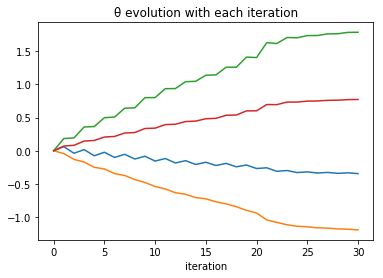

In [31]:
# initialise θ
θ_init = np.zeros((X.shape[1],1))
# generate instance of GLR class
GLR = Generic_LogisticRegression(θ_init, sigmoid) 
# fitting the data
GLR.fit(X,y)
print("Optimal parameter=",GLR.θ)
#prediction
ypred =  GLR.predict(X)

In [32]:
# calculate accuracy score
1-(np.abs(y-ypred)).mean()

1.0

In [33]:
# Compute log_loss
from sklearn.metrics import log_loss
logloss = log_loss(y, GLR.predict_proba(X))
print(logloss)

0.05057778406985766


In [34]:
# Print classification report
from sklearn.metrics import classification_report
report = classification_report(y, GLR.predict(X))
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

   micro avg       1.00      1.00      1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



Text(0, 0.5, 'Cost value')

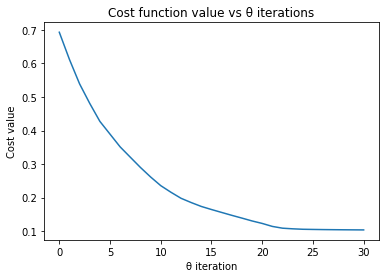

In [35]:
# Plot evolution of the cost function through iterations of θ
cost_iterations = np.zeros((len(GLR.θ_iterations),1))
for i,theta in enumerate(GLR.θ_iterations):
    cost_iterations[i] = -(1.0/X.shape[0]) * (np.dot(y.T, np.log(GLR.sigmoid(np.dot(X, theta)))) + np.dot((1-y.T), np.log(1-GLR.sigmoid(np.dot(X, theta))))) + (GLR.α * np.sum(theta**2))
    #np.sum(-loss(X,y,theta, logistic)) + (1/Optimimparam["C"])*np.linalg.norm(theta)**2
plt.plot(range(len(GLR.θ_iterations)),cost_iterations)
plt.title("Cost function value vs θ iterations")
plt.xlabel("θ iteration")
plt.ylabel("Cost value")

In [79]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X, y[:,0])
clf.score(X, y[:,0])

C:\Users\rgiller\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.0

Text(0.5, 1.0, 'Logreg from sklearn Classifications')

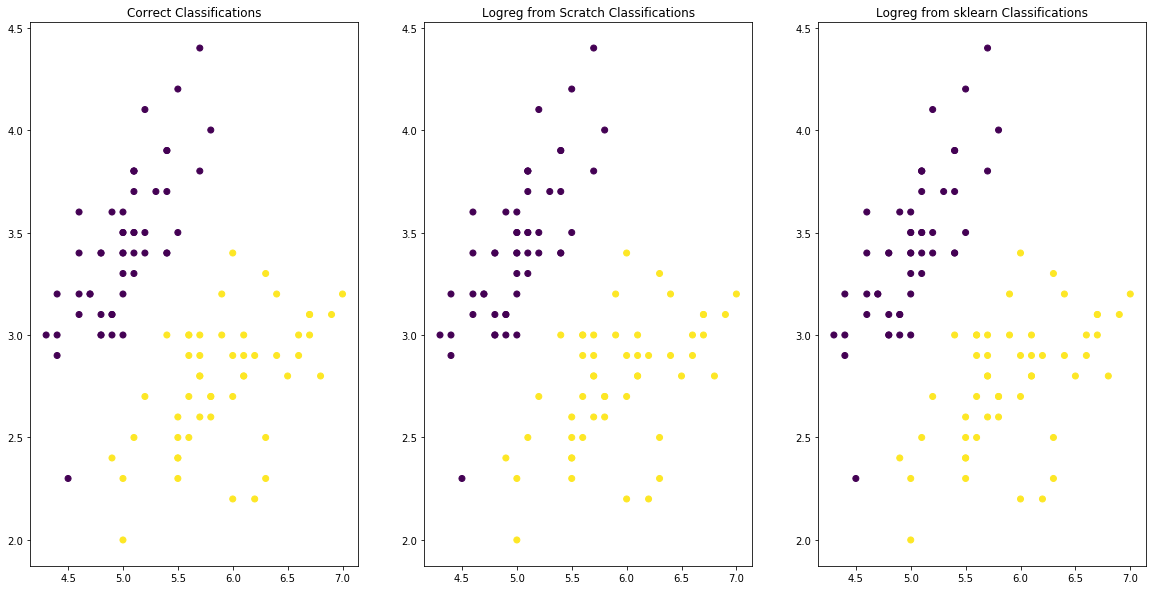

In [80]:
# plot classifications: given labels, classification from scratch, classification from sklearn
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.scatter(X[:,0], X[:,1], c = y[:,0])
plt.title("Correct Classifications")
plt.subplot(132)
plt.scatter(X[:,0], X[:,1], c = GLR.predict(X)[:,0])
plt.title("Logreg from Scratch Classifications")
plt.subplot(133)
plt.scatter(X[:,0], X[:,1], c = clf.predict(X))
plt.title("Logreg from sklearn Classifications")

In [81]:
print(clf.coef_)

[[-0.40247392 -1.46382925  2.23785648  1.00009294]]


## Logistic regression code produces same performance as sklearn for iris dataset. Optimum coefficients are approximately equal, accuracy score is the same. The routine reduces the cost function with each optimisation iteration and the optimisation parameter values look to be converging (although more iterations are needed). The log_loss is close to zero. Need to test on a dataset that isn't linearly separable, as this one is

## Test 2: Sklearn metrics and ROC curves. K-fold CV

In [39]:
from itertools import cycle

from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold

from scipy import interp

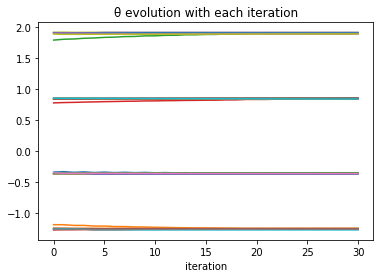

In [40]:
# Initialise some arrays to store sklearn metrics per CV fold
mean_fpr = np.linspace(start=0, stop=1, num=100)
GLR_accuracies = np.array([])
GLR_f1_scores = np.array([])
GLR_tprs = np.empty(shape=[0,mean_fpr.shape[0]])
GLR_aucs = np.array([])

# cv is a k-fold cross-valiatidation object
cv = StratifiedKFold(n_splits=10)

# Loop to run the K-fold test and record sklearn metric scores each time
for train, test in cv.split(X, y):
    # train the classifier and compute the classes for the test set
    _model = GLR.fit(X[train], y[train])
    _probabilities = GLR.predict_proba(X[test])
    _predictions = GLR.predict(X[test])

    # compute accuracy
    GLR_accuracies = np.append(GLR_accuracies, accuracy_score(y[test], _predictions))

    # compute f1 score
    GLR_f1_scores = np.append(GLR_f1_scores, f1_score(y[test], _predictions))

    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _thresholds = roc_curve(y_true = y[test], y_score = _probabilities[:, 0])

    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    GLR_tprs = np.concatenate((GLR_tprs, _tpr_transformed), axis=0)

    # compute the area under the curve
    GLR_aucs = np.append(GLR_aucs, auc(_fpr, _tpr))


In [41]:
# Function to plot ROC curves for each fold
def plot_roc_cv_folds(mean_fpr, tprs, aucs, classifier_name):
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    for i in range(0, aucs.shape[0]):
        plt.plot(mean_fpr, tprs[i,:], lw=1, alpha=0.3,label='fold %d (AUC = %0.2f)' % (i, aucs[i]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves for %d cross-validation folds: %s' % (aucs.shape[0], classifier_name))
    plt.legend(loc="lower right")
    plt.show()

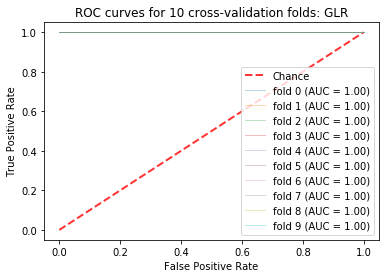

In [42]:
plot_roc_cv_folds(mean_fpr, GLR_tprs, GLR_aucs, 'GLR')

In [43]:
def plot_roc_mean(mean_fpr, tprs, aucs, classifier_name):
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # ROC curve - mean curve for all cross-validation runs
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # colour in grey the area of the standard deviation from the mean tpr
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC curve for all cross-validation runs: ' + classifier_name)
    plt.legend(loc="lower right")
    plt.show()

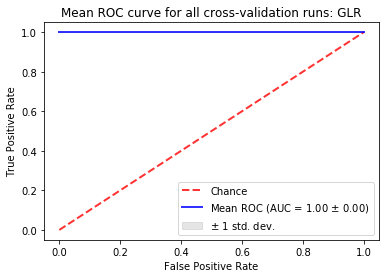

In [44]:
plot_roc_mean(mean_fpr, GLR_tprs, GLR_aucs, 'GLR')

## AUC for each K-fold is 1, as the data is linearly separable

## Test 3: PCA reduce to 2 dimensions and plot decision boundaries

In [46]:
from sklearn.decomposition import PCA
skl_pca = PCA(n_components = 2)
skl_pca.fit(X)
X_reduced = skl_pca.transform(X)

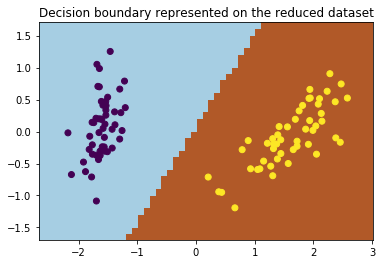

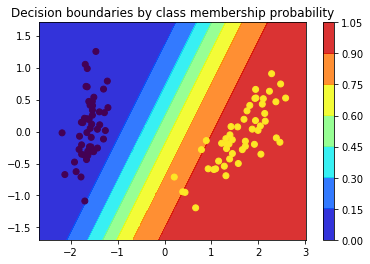

In [50]:
# Create mesh grid around PCA-reduced data set

x_min, x_max = X_reduced[:, 0].min() - .5, X_reduced[:, 0].max() + .5
y_min, y_max = X_reduced[:, 1].min() - .5, X_reduced[:, 1].max() + .5
h = .1  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
reduced_gridpoints = np.c_[xx.ravel(), yy.ravel()]
#project the meshgrid points onto the full dataset's eigenbasis
proj_reduced_gridpoints = skl_pca.inverse_transform(reduced_gridpoints)
#calculate classification results for the grid points
Z = GLR.predict(proj_reduced_gridpoints)
Z_proba = GLR.predict_proba(proj_reduced_gridpoints)
Z = Z.reshape(xx.shape)
Z_proba = Z_proba.reshape(xx.shape)
#plot the decision boundary overlaid with the labeled reduced dataset
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(X_reduced[:,0],X_reduced[:,1],c = y[:,0])
plt.title("Decision boundary represented on the reduced dataset")
plt.show()
#plot the probability of survival as a contour, overlaid with the labeled reduced dataset
plt.figure()
plt.contourf(xx, yy, Z_proba, cmap=plt.cm.jet, alpha=.8)
plt.colorbar()
plt.scatter(X_reduced[:,0],X_reduced[:,1],c = y[:,0])
plt.title("Decision boundaries by class membership probability")
plt.show()


## Decision boundary seems to be in right position

## Test 4: compare vs sklearn logreg for more complex dataset

In [53]:
# Load data set into X1 and y1
from sklearn.datasets import load_breast_cancer

X1,y1 = load_breast_cancer(return_X_y=True)

In [59]:
y1 = np.reshape(y1, (y1.shape[0], 1))

C:\Users\rgiller\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


Optimal parameter= [[ 1.22686448e-03]
 [ 2.28201674e-03]
 [ 7.46245243e-03]
 [ 8.74345798e-03]
 [ 1.29701448e-05]
 [ 3.56277436e-06]
 [-8.46449795e-06]
 [-4.22179292e-06]
 [ 2.45440278e-05]
 [ 9.78710878e-06]
 [ 7.78530634e-06]
 [ 1.82343955e-04]
 [ 3.86438176e-05]
 [-2.44997468e-03]
 [ 1.12110139e-06]
 [ 1.62622582e-06]
 [ 1.53789399e-06]
 [ 7.37236632e-07]
 [ 3.03787661e-06]
 [ 4.78013626e-07]
 [ 1.19160917e-03]
 [ 2.90275943e-03]
 [ 7.19111564e-03]
 [-7.89625831e-03]
 [ 1.69625595e-05]
 [ 2.71811263e-06]
 [-1.24936909e-05]
 [-2.44819446e-06]
 [ 3.51710640e-05]
 [ 1.07560948e-05]]


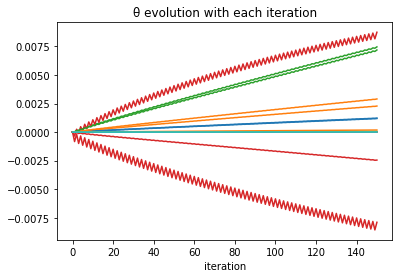

In [117]:
# Fit generic logistic regression
# initialise θ
θ_init1 = np.zeros((X1.shape[1],1))
# generate instance of GLR class
GLR1 = Generic_LogisticRegression(θ_init1, sigmoid) 
# fitting the data
GLR1.fit(X1,y1)
print("Optimal parameter=",GLR1.θ)
#prediction
ypred1 =  GLR1.predict(X1)

In [118]:
# calculate accuracy score
1-(np.abs(y1-ypred1)).mean()

0.8471001757469244

In [119]:
# Define K-fold function to generate metrics for each fold
# K-fold CV function to compare logreg vs sklearn
mean_fpr = np.linspace(start=0, stop=1, num=100)


# cv is a k-fold cross-valiatidation object
cv = StratifiedKFold(n_splits=10)

# Loop to run the K-fold test and record sklearn metric scores each time
def evaluate_classifier(folds, X, y, classifier, mean_fpr, prob_axis):
    GLR_accuracies = np.array([])
    GLR_f1_scores = np.array([])
    GLR_tprs = np.empty(shape=[0,mean_fpr.shape[0]])
    GLR_aucs = np.array([])
    for train, test in cv.split(X, y):
        # train the classifier and compute the classes for the test set
        _model = classifier.fit(X[train], y[train])
        _probabilities = classifier.predict_proba(X[test])
        _predictions = classifier.predict(X[test])

        # compute accuracy
        GLR_accuracies = np.append(GLR_accuracies, accuracy_score(y[test], _predictions))

        # compute f1 score
        GLR_f1_scores = np.append(GLR_f1_scores, f1_score(y[test], _predictions))

        # compute fpr and tpr values for various thresholds 
        # by comparing the true target values to the predicted probabilities for class 1
        _fpr, _tpr, _thresholds = roc_curve(y_true = y[test], y_score = _probabilities[:, prob_axis])

        # compute true positive rates for the values in the array mean_fpr
        _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
        GLR_tprs = np.concatenate((GLR_tprs, _tpr_transformed), axis=0)

        # compute the area under the curve
        GLR_aucs = np.append(GLR_aucs, auc(_fpr, _tpr))
    return GLR_accuracies, GLR_f1_scores, GLR_tprs, GLR_aucs

C:\Users\rgiller\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


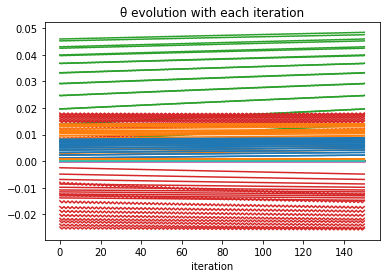

In [120]:
# Store metrics for 10 fold CV for generic logreg
accuracies_GLR1, f1_scores_GLR1, tprs_GLR1, aucs_GLR1 = evaluate_classifier(folds=10, 
                                                                    X=X1, y=y1, 
                                                                    classifier=GLR1, 
                                                                    mean_fpr=mean_fpr, prob_axis=0)

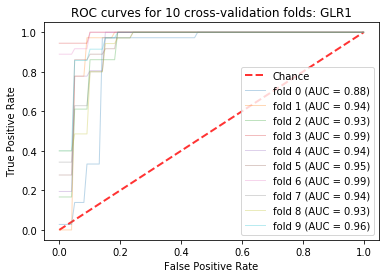

In [121]:
# Plot a ROC curve for each cross-validation fold for generic logreg
plot_roc_cv_folds(mean_fpr, tprs_GLR1, aucs_GLR1, 'GLR1')

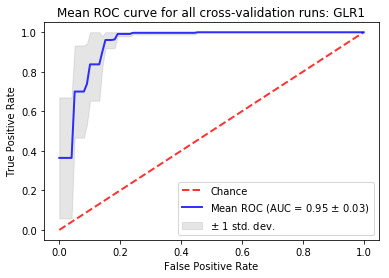

In [122]:
# Plot a mean ROC curve for all cross-validation runs for generic logreg
plot_roc_mean(mean_fpr, tprs_GLR1, aucs_GLR1, 'GLR1')

In [123]:
# Fit sklearn logreg - use y1[:,0]
clf1 = LogisticRegression(random_state=0)
clf1.fit(X1, y1[:,0])
clf1.score(X1, y1[:,0])

C:\Users\rgiller\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9595782073813708

In [124]:
# store metrics for sklearn logreg
accuracies_clf1, f1_scores_clf1, tprs_clf1, aucs_clf1 = evaluate_classifier(folds=10, 
                                                                    X=X1, y=y1[:,0], 
                                                                    classifier=clf1, 
                                                                    mean_fpr=mean_fpr, prob_axis=1)

C:\Users\rgiller\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rgiller\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rgiller\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rgiller\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rgiller\AppData\Local\Continuum\anaconda3\lib\site-packages\skl

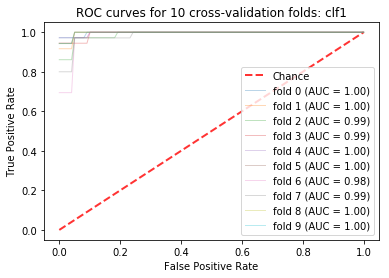

In [125]:
# Plot a ROC curve for each cross-validation fold for sklearn logreg
plot_roc_cv_folds(mean_fpr, tprs_clf1, aucs_clf1, 'clf1')

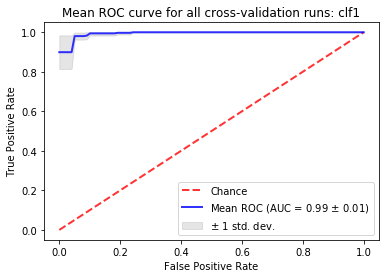

In [126]:
# Plot a mean ROC curve for all cross-validation runs for sklearn logreg
plot_roc_mean(mean_fpr, tprs_clf1, aucs_clf1, 'clf1')

In [127]:
# define function to plot roc curves for multiple classifiers
def plot_roc_multiple_classifiers(mean_fpr, tprs, aucs, classifier_names):
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    for i in range(0, aucs.shape[0]):
        plt.plot(mean_fpr, tprs[i,:], lw=2, alpha=0.8,label='%s (AUC = %0.2f)' % (classifier_names[i], aucs[i]))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves for multiple classifiers')
    plt.legend(loc="lower right")
    plt.show()

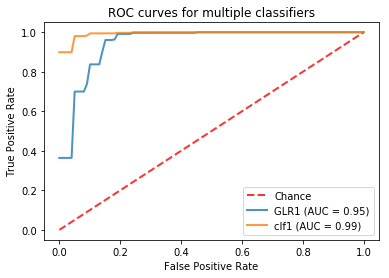

In [128]:
# overlay ROC curves for generic logreg and sklearn logreg
plot_roc_multiple_classifiers(mean_fpr, np.stack((np.mean(tprs_GLR1, axis=0), np.mean(tprs_clf1, axis=0))), 
                              np.array([np.mean(aucs_GLR1), np.mean(aucs_clf1)]), 
                              np.array(['GLR1', 'clf1']))

In [130]:
# store metrics in a pandas dataframe to compare stats
import pandas as pd
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_df = pd.DataFrame(data={'GLR1' : accuracies_GLR1, 'clf1s' : accuracies_clf1})

In [131]:
accuracies_df.describe()

GLR1      clf1s
count  10.000000  10.000000
mean    0.910479   0.950900
std     0.027387   0.019503
min     0.862069   0.913793
25%     0.892857   0.946664
50%     0.920426   0.947822
75%     0.929825   0.964286
max     0.947368   0.982456

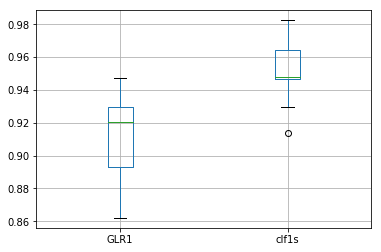

In [132]:
# Box plot accuracies for comparison
accuracies_df.boxplot()

In [133]:
# Compare the statistics of the F1-scores across all cross-validation folds
f1_scores_df = pd.DataFrame(data={'GLR1' : f1_scores_GLR1, 'clf1' : f1_scores_clf1})

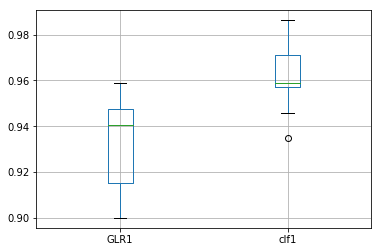

In [134]:
# Box plot f1 scores for comparison
f1_scores_df.boxplot()

## sklearn logreg performs better than generic logreg, however with more iterations of the optimisation algorithm in generic logreg, the performance can be comparable. The boxplots here (with 150 iterations of optimiser) show higher mean and lower IQR for sklearn vs generic logreg in metrics of accuracy and F1. Graph above also shows greater mean AUC for sklearn vs generic logreg